In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

In [12]:
housing = fetch_california_housing()

In [14]:
x_train_full, x_test, y_train_full, y_test = train_test_split(
housing.data, housing.target)

In [15]:
x_train, x_valid, y_train, y_valid = train_test_split(
x_train_full, y_train_full)

In [16]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.fit_transform(x_valid)
x_test = scaler.fit_transform(x_test)

In [19]:
x_train_A, x_train_B = x_train[:, :5], x_train[:, 2:]
x_valid_A, x_valid_B = x_valid[:, :5], x_valid[:, 2:]
x_test_A, x_test_B = x_test[:, :5], x_test[:, 2:]
x_new_A, x_new_B = x_test_A[:3], x_test_B[:3]

#### Tips

In [2]:
# to change kernel initializer
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2, mode='fan_avg', distribution='uniform')
tf.keras.layers.Dense(10, activation='sigmoid', kernel_initializer=he_avg_init)

In [3]:
# batch norm can be used before activation
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, kernel_initializer='he_normal', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('elu')
])

In [5]:
# gradient clipping 
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss='mse', optimizer=optimizer)

In [23]:
# tranfer learning 
model_A = tf.keras.models.load_model('simple_keras_california_housing.h5', )
model_B_on_A = tf.keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation='sigmoid'))
# note: model_A and model_B_on_A now share some layers, when train B, this would affect A
# to avoid this, do below
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [24]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False
    
model_B_on_A.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [27]:
history = model_B_on_A.fit(x_train, y_train, epochs=4,
                          validation_data=(x_valid, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/4
11610/11610 [==============================] - 2s 162us/sample - loss: -11.1239 - accuracy: 0.0028 - val_loss: -19.6501 - val_accuracy: 0.0049
Epoch 2/4
11610/11610 [==============================] - 1s 98us/sample - loss: -33.9084 - accuracy: 0.0029 - val_loss: -39.1344 - val_accuracy: 0.0049
Epoch 3/4
11610/11610 [==============================] - 1s 107us/sample - loss: -56.5157 - accuracy: 0.0029 - val_loss: -58.6228 - val_accuracy: 0.0049
Epoch 4/4
11610/11610 [==============================] - 1s 100us/sample - loss: -79.1281 - accuracy: 0.0029 - val_loss: -78.1184 - val_accuracy: 0.0049


In [28]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

In [29]:
optimizer = keras.optimizers.SGD(lr=1e-4)
model_B_on_A.compile(loss='binary_crossentropy', optimizer=optimizer,
                    metrics=['accuracy'])
history = model_B_on_A.fit(x_train, y_train, epochs=16, validation_data=(x_valid, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/16
11610/11610 [==============================] - 2s 151us/sample - loss: -121.2404 - accuracy: 0.0029 - val_loss: -139.5651 - val_accuracy: 0.0049
Epoch 2/16
11610/11610 [==============================] - 1s 107us/sample - loss: -186.8177 - accuracy: 0.0029 - val_loss: -205.7672 - val_accuracy: 0.0049
Epoch 3/16
11610/11610 [==============================] - 1s 111us/sample - loss: -256.6298 - accuracy: 0.0029 - val_loss: -275.5233 - val_accuracy: 0.0049
Epoch 4/16
11610/11610 [==============================] - 1s 99us/sample - loss: -330.1946 - accuracy: 0.0029 - val_loss: -348.9744 - val_accuracy: 0.0049
Epoch 5/16
11610/11610 [==============================] - 1s 76us/sample - loss: -407.7628 - accuracy: 0.0029 - val_loss: -426.4359 - val_accuracy: 0.0049
Epoch 6/16
11610/11610 [==============================] - 1s 84us/sample - loss: -489.7601 - accuracy: 0.0029 - val_loss: -508.4761 - val_accuracy: 0.0049
Epoch 7/16
11610/1

#### learning rate scheduler

In [30]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [31]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

In [33]:
exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(x_train, y_train, ....., callbacks=[lr_scheduler])

#### CIFAR1

In [3]:
# a
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer="he_normal"))

In [4]:
# b
model.add(keras.layers.Dense(10, activation="softmax"))

In [5]:
optimizer = keras.optimizers.Nadam(lr=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [6]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

In [7]:
import os
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/my_cifar10_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_logs/my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [11]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 32s 705us/sample - loss: 4.2309 - accuracy: 0.1742 - val_loss: 2.2667 - val_accuracy: 0.1956
Epoch 2/100
45000/45000 [==============================] - 26s 588us/sample - loss: 2.0889 - accuracy: 0.2439 - val_loss: 2.0336 - val_accuracy: 0.2452
Epoch 3/100
45000/45000 [==============================] - 27s 596us/sample - loss: 1.9671 - accuracy: 0.2820 - val_loss: 1.9812 - val_accuracy: 0.2768
Epoch 4/100
45000/45000 [==============================] - 27s 599us/sample - loss: 1.8840 - accuracy: 0.3136 - val_loss: 1.8821 - val_accuracy: 0.2990
Epoch 5/100
45000/45000 [==============================] - 27s 595us/sample - loss: 1.8157 - accuracy: 0.3417 - val_loss: 1.7846 - val_accuracy: 0.3424
Epoch 6/100
45000/45000 [==============================] - 26s 580us/sample - loss: 1.7609 - accuracy: 0.3630 - val_loss: 1.7992 - val_accuracy: 0.3458
Epoch 7/100
45000/45000 [==============

45000/45000 [==============================] - 27s 610us/sample - loss: 1.1936 - accuracy: 0.5695 - val_loss: 1.5916 - val_accuracy: 0.4558
Epoch 55/100
45000/45000 [==============================] - 26s 580us/sample - loss: 1.1893 - accuracy: 0.5733 - val_loss: 1.6269 - val_accuracy: 0.4462


In [12]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [13]:
%tensorboard --logdir=./my_logs/my_cifar10_logs --port=6006

Reusing TensorBoard on port 6006 (pid 31224), started 12:38:55 ago. (Use '!kill 31224' to kill it.)

In [16]:
model = keras.models.load_model("./model/my_cifar10_model.h5")
model.evaluate(X_valid, y_valid)

5000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.506447829246521, 0.4688]

In [18]:
import numpy as np
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/my_cifar10_bn_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_logs/my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [19]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 88s 2ms/sample - loss: 1.8392 - accuracy: 0.3408 - val_loss: 1.6386 - val_accuracy: 0.4142
Epoch 2/100
45000/45000 [==============================] - 68s 2ms/sample - loss: 1.6677 - accuracy: 0.4072 - val_loss: 1.6207 - val_accuracy: 0.4236
Epoch 3/100
45000/45000 [==============================] - 65s 1ms/sample - loss: 1.5977 - accuracy: 0.4327 - val_loss: 1.5449 - val_accuracy: 0.4562
Epoch 4/100
45000/45000 [==============================] - 65s 1ms/sample - loss: 1.5533 - accuracy: 0.4491 - val_loss: 1.5059 - val_accuracy: 0.4572
Epoch 5/100
45000/45000 [==============================] - 65s 1ms/sample - loss: 1.5009 - accuracy: 0.4654 - val_loss: 1.4660 - val_accuracy: 0.4736
Epoch 6/100
45000/45000 [==============================] - 64s 1ms/sample - loss: 1.4606 - accuracy: 0.4801 - val_loss: 1.4165 - val_accuracy: 0.4902
Epoch 7/100
45000/45000 [==========================

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/my_cifar10_selu_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_logs/my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("./model/my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 51s 1ms/sample - loss: 1.9176 - accuracy: 0.3150 - val_loss: 1.7412 - val_accuracy: 0.3824
Epoch 2/100
45000/45000 [==============================] - 46s 1ms/sample - loss: 1.6991 - accuracy: 0.3968 - val_loss: 1.7358 - val_accuracy: 0.3834
Epoch 3/100
45000/45000 [==============================] - 42s 925us/sample - loss: 1.6013 - accuracy: 0.4337 - val_loss: 1.6447 - val_accuracy: 0.4238
Epoch 4/100
45000/45000 [==============================] - 43s 947us/sample - loss: 1.5371 - accuracy: 0.4577 - val_loss: 1.6274 - val_accuracy: 0.4136
Epoch 5/100
45000/45000 [==============================] - 40s 891us/sample - loss: 1.4792 - accuracy: 0.4788 - val_loss: 1.6523 - val_accuracy: 0.4354
Epoch 6/100
45000/45000 [==============================] - 41s 902us/sample - loss: 1.4354 - accuracy: 0.4985 - val_loss: 1.5426 - val_accuracy: 0.4610
Epoch 7/100
45000/45000 [==================

[1.4766204376220704, 0.488]

In [23]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/my_cifar10_alpha_dropout_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_logs/my_cifar10_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("./model/my_cifar10_alpha_dropout_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 47s 1ms/sample - loss: 1.8857 - accuracy: 0.3299 - val_loss: 1.6989 - val_accuracy: 0.4070
Epoch 2/100
45000/45000 [==============================] - 42s 930us/sample - loss: 1.6595 - accuracy: 0.4145 - val_loss: 1.6847 - val_accuracy: 0.4120
Epoch 3/100
45000/45000 [==============================] - 41s 913us/sample - loss: 1.5732 - accuracy: 0.4494 - val_loss: 1.6092 - val_accuracy: 0.4398
Epoch 4/100
45000/45000 [==============================] - 40s 890us/sample - loss: 1.5107 - accuracy: 0.4704 - val_loss: 1.6015 - val_accuracy: 0.4560
Epoch 5/100
45000/45000 [==============================] - 40s 882us/sample - loss: 1.4574 - accuracy: 0.4893 - val_loss: 1.6110 - val_accuracy: 0.4596
Epoch 6/100
45000/45000 [==============================] - 39s 878us/sample - loss: 1.4073 - accuracy: 0.5084 - val_loss: 1.5113 - val_accuracy: 0.4756
Epoch 7/100
45000/45000 [================

[1.4933519033432008, 0.4966]

In [24]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [28]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout)
            else layer
            for layer in model.layers
])

In [29]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

In [30]:
# keras.backend.clear_session()
# tf.random.set_seed(42)
# np.random.seed(42)

# y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
# accuracy = np.mean(y_pred == y_valid[:, 0])
# accuracy

ValueError: Unknown graph. Aborting.

In [37]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [41]:
# 1Cycle scheduling
import math
import matplotlib.pyplot as plt
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

Train on 45000 samples
45000/45000 [==============================] - 18s 392us/sample - loss: nan - accuracy: 0.1380


(9.999999747378752e-06,
 9.615227699279785,
 2.050062894821167,
 3.575478281293597)

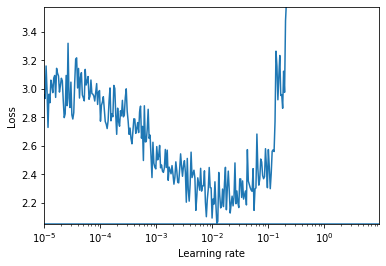

In [42]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [48]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [49]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=1e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [50]:
n_epochs = 15
onecycle = OneCycleScheduler(math.ceil(len(X_train_scaled) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 22s 486us/sample - loss: 2.0526 - accuracy: 0.2844 - val_loss: 1.7812 - val_accuracy: 0.3850
Epoch 2/15
45000/45000 [==============================] - 18s 405us/sample - loss: 1.7643 - accuracy: 0.3771 - val_loss: 1.6554 - val_accuracy: 0.4178
Epoch 3/15
45000/45000 [==============================] - 19s 427us/sample - loss: 1.6283 - accuracy: 0.4218 - val_loss: 1.6005 - val_accuracy: 0.4358
Epoch 4/15
45000/45000 [==============================] - 19s 430us/sample - loss: 1.5501 - accuracy: 0.4508 - val_loss: 1.5674 - val_accuracy: 0.4462
Epoch 5/15
45000/45000 [==============================] - 19s 416us/sample - loss: 1.4952 - accuracy: 0.4705 - val_loss: 1.6695 - val_accuracy: 0.4296
Epoch 6/15
45000/45000 [==============================] - 18s 402us/sample - loss: 1.4617 - accuracy: 0.4806 - val_loss: 1.5615 - val_accuracy: 0.4550
Epoch 7/15
45000/45000 [=====================